# Interface from TBmodels to kwant

Prerequisites:
* TBmodels
* kwant
* wraparound (https://gitlab.kwant-project.org/cwg/wraparound/)

In [1]:
import kwant
import tbmodels
import wraparound

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/greschd/.virtualenvs/tbmodels_kwant_test/lib/python3.5/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


## Bulk Hamiltonian with wraparound

In this first example, we compare the bulk Hamiltonian from TBmodels with that of the model in kwant, using wraparound.

In [2]:
model = tbmodels.Model.from_wannier_files(hr_file='data/wannier90_hr.dat')

First we need to create the lattice from the tight-binding model and define the translation symmetries.

In [3]:
lattice = model.to_kwant_lattice()

In [4]:
sym = kwant.TranslationalSymmetry(
    lattice.vec((1, 0, 0)),
    lattice.vec((0, 1, 0)),
    lattice.vec((0, 0, 1))
)

Now we define a Builder with these symmetries

In [5]:
kwant_sys = kwant.Builder(sym)

We give the system an "infinite" shape. This needs to be done **before** adding the hoppings, because on-site energies and hoppings are added only to existing sites.

In [6]:
kwant_sys[lattice.shape(lambda p: True, (0, 0, 0))] = 0

Now we can add the hoppings. This modifies the model in-place.

In [7]:
model.add_hoppings_kwant(kwant_sys)

Finally, use wraparound to finalize the bulk system:

In [8]:
kwant_model = wraparound.wraparound(kwant_sys).finalized()

To see that the two models are the same, we plot the bands along some line. Note that the periodicity of the k-vector is $1$ in TBmodels, but $2\pi$ in kwant. The k-vector needs to be scaled accordingly.

In [9]:
k_list = [(kx, 0, 0) for kx in np.linspace(0, 1, 100)]
x = range(100)

In [10]:
eigs_tbmodels = [model.eigenval(k) for k in k_list]
eigs_kwant = [la.eigvalsh(
    kwant_model.hamiltonian_submatrix(2 * np.pi * np.array(k))
) for k in k_list]

Numerical and visual test for equivalence:

In [11]:
np.isclose(eigs_tbmodels, eigs_kwant).all()

True

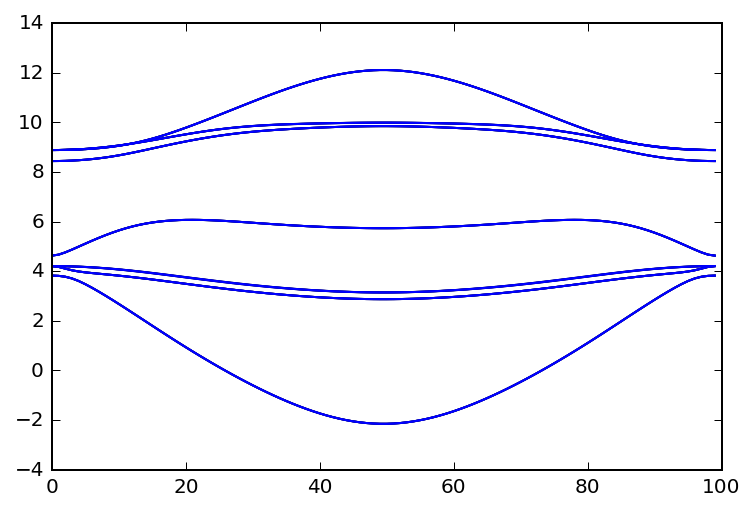

In [12]:
fig, ax = plt.subplots()
for band in np.array(eigs_tbmodels).T:
    ax.plot(x, band, 'k')
for band in np.array(eigs_kwant).T:
    ax.plot(x, band, 'b')

## Finite wire with leads

In the second example, we build a finite wire and attach two leads on either side.

Since the finite wire doesn't have translation symmetry, we can just create a bare Builder.

In [13]:
wire = kwant.Builder()

Now we define a shape for the wire - for simplicity we use a square.

In [14]:
def shape(p):
    x, y, z = p
    return -20 < x < 20 and -5 < y < 5 and -5 < z < 5

Again, we explicitly create the lattice sites before populating the hoppings.

In [15]:
wire[lattice.shape(shape, (0, 0, 0))] = 0
model.add_hoppings_kwant(wire)

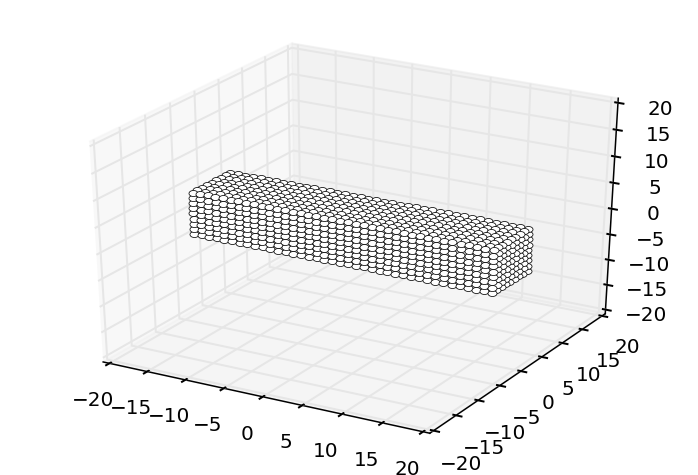

In [16]:
kwant.plot(wire);

Now we create and attach two leads on either side. The lead must be long enough s.t. the most long-range hopping stays within the lead.

In [17]:
sym_lead = kwant.TranslationalSymmetry(lattice.vec((-5, 0, 0)))
lead = kwant.Builder(sym_lead)
def lead_shape(p):
    x, y, z = p
    return -5 <= x <= 0 and -5 < y < 5 and -5 < z < 5
lead[lattice.shape(lead_shape, (0, 0, 0))] = 0
model.add_hoppings_kwant(lead)

In [18]:
wire.attach_lead(lead);
wire.attach_lead(lead.reversed());

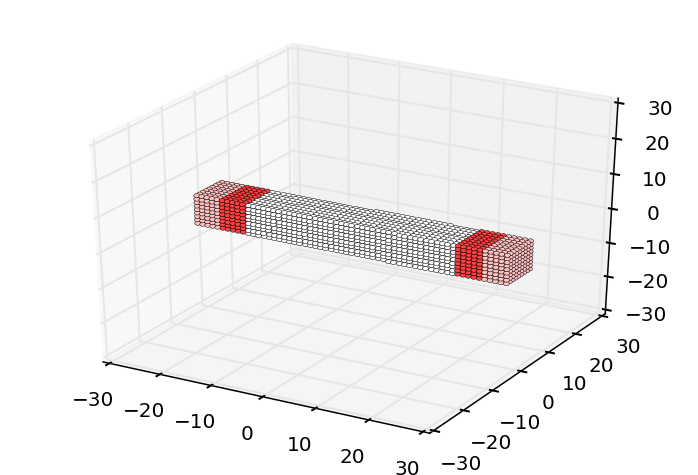

In [19]:
kwant.plot(wire);

Here's how you can find out what's the longest-range hopping in a given direction:

In [23]:
for i, dir in enumerate(['x', 'y', 'z']):
    print(dir + ':', max([abs(R[i]) for R in model.hop.keys()]))

x: 5
y: 5
z: 5
